In [2]:
%load_ext autoreload
%autoreload 2
import sys
from tqdm import tqdm

import numpy as np
from scipy import fft
from scipy.signal import convolve
from scipy.constants import pi

import matplotlib.pyplot as plt

import diffractsim as ds

sys.path.append("C:/Users/1167306/py-libs/optics/src/")
import fourierhelper as fo

mm_ = 1e-3
um_ = 1e-6
nm_ = 1e-9

In [548]:
FIBER_XY0 = np.array([
    [0,0],
    [1,0],
    [0,1],
    [-1,-1],
    [1,-2],
    [3,0],
    [-2,3],
    [1,4],
    [-3,-4],
    [-5,1],
    [7,0],
    [1,-7],
    [-8,-2],
    [6,-6],
    [3,8],
    [-7,8],
    [-6,-10],
    [11,5],
    [5,-11],
    [-12,4]
])

FIBER_XY0 = np.array([
    [0,0],
    [1.31, 2.077],
    [-0.2, 1.72],
    [-2.14, -0.7]
])

# normconst = 0.5 / np.max(np.abs(FIBER_XY0))
normconst = 0.15 

FIBER_XY0 = FIBER_XY0 * normconst
for xy in FIBER_XY0:
    print(f'{xy[0]:12.9f}, {xy[1]:12.9f}')

 0.000000000,  0.000000000
 0.196500000,  0.311550000
-0.030000000,  0.258000000
-0.321000000, -0.105000000


# Fringe formation
---

In [439]:
U_WAVELENGTH = 500 * nm_
U_WAVENUMBER = 2*np.pi / U_WAVELENGTH
U_PIXELPITCH = 5 * mm_
U_SIZE_N = 2048
FOCAL_LEN1 = 0.01
FOCAL_LEN2 = 1
DIST_PROPAGATE = 5.0

print(U_SIZE_N*U_PIXELPITCH)
rowvec = U_PIXELPITCH * np.linspace( -U_SIZE_N//2, U_SIZE_N//2-1, U_SIZE_N, dtype=np.float64)
xx, yy =  np.meshgrid( rowvec, rowvec )
FIBER_XWIDTH = 75.0 * mm_
FIBER_YWIDTH = 75.0 * mm_
BEAM_WAIST = FIBER_XWIDTH / 2

rng = np.random.default_rng(seed=123)
FIBER_PHI = 0.0 * 2*pi*rng.random(FIBER_XY0.shape[0])
# FIBER_PHI = np.array([0.0, 0*pi])

U_0 = np.zeros_like(xx)
# make initial field
for xy,phi in zip(FIBER_XY0,FIBER_PHI):
    x0, y0 = xy

    Ui = fo.circ2d(xx, yy, x0, y0, FIBER_XWIDTH, FIBER_YWIDTH) 

    Efld_GaussiaBeam = fo.efield_guassian_2d( xx - x0, yy - y0, U_WAVELENGTH, BEAM_WAIST )

    Ui = Ui * Efld_GaussiaBeam * np.exp( 1j*phi )

    U_0 = U_0 + Ui

MIDPOINT_SCALE = 1
mid_size_x, mid_size_y = U_SIZE_N*MIDPOINT_SCALE, U_SIZE_N*MIDPOINT_SCALE

# CDD_PIXELPITCH = 0.25 * mm_
CDD_PIXELPITCH = 0.25 * mm_
ccd_size_x, ccd_size_y = U_SIZE_N*CDD_PIXELPITCH, U_SIZE_N*CDD_PIXELPITCH
# init monochromatic sim
F = ds.MonochromaticField(U_WAVELENGTH, U_PIXELPITCH*U_SIZE_N, U_PIXELPITCH*U_SIZE_N, U_SIZE_N, U_SIZE_N )
F.E = U_0.copy()

# F.add(ds.Lens(f = FOCAL_LEN))
# F.propagate(DIST_PROPAGATE)
# F.add(ds.Lens(f = FOCAL_LEN1))
# F.scale_propagate(FOCAL_LEN1+FOCAL_LEN2, scale_factor=MIDPOINT_SCALE)
# F.propagate(FOCAL_LEN1+FOCAL_LEN2)
# # F.zoom_propagate(FOCAL_LEN1+FOCAL_LEN2, x_interval=[-mid_size_x/2, mid_size_x/2], y_interval=[-mid_size_y/2, mid_size_y/2])
F.add(ds.Lens(f = FOCAL_LEN2))
# F.scale_propagate(DIST_PROPAGATE, scale_factor=CDD_PIXELPITCH)
F.zoom_propagate(DIST_PROPAGATE, x_interval=[-ccd_size_x/2, ccd_size_x/2], y_interval=[-ccd_size_y/2, ccd_size_y/2])



# F.zoom_propagate(2, x_interval=[-ccd_size_x/2, ccd_size_x/2], y_interval=[-ccd_size_y/2, ccd_size_y/2])

U_z = F.E.copy() # diffraction of initial field

# # CCD meshgrid i.e. output screen 
# xvec = np.linspace(-ccd_size_x/2, ccd_size_x/2, U_SIZE_N)
# yvec = np.linspace(-ccd_size_y/2, ccd_size_y/2, U_SIZE_N)
# ccd_xx, ccd_yy = np.meshgrid( xvec, yvec )



10.24


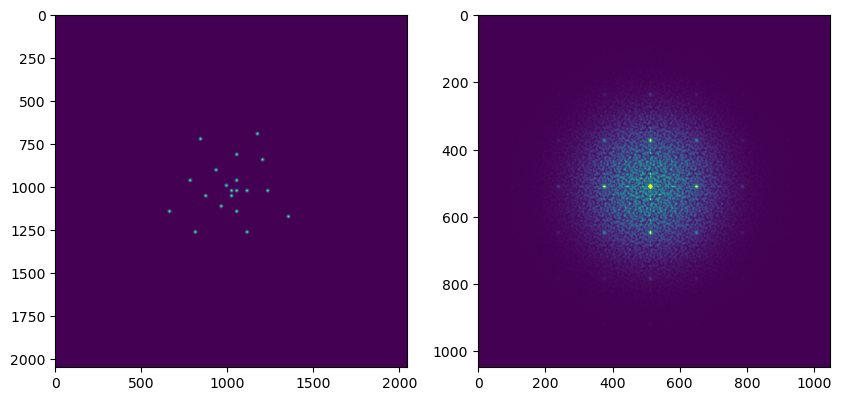

In [446]:
fig, (ax_u0, ax_uz ) = plt.subplots(1,2, figsize=(10,11))

ax_u0.imshow(np.abs(U_0), vmin=0, vmax=1)

fpaplot = np.abs(U_z) 
fpaplot = np.fft.fftshift(np.abs(U_z) )
# fpaplot = fpaplot[200:800,200:800]
fpaplot = fpaplot[512:1560,512:1560]
ax_uz.imshow( fpaplot , vmax=5e3)
# ax_uz.imshow( fpaplot )

plt.show()

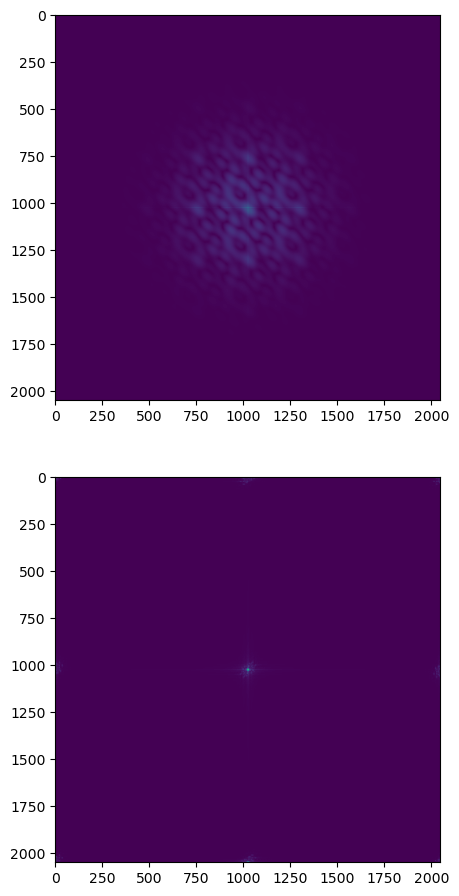

In [144]:
fig, (ax_u0, ax_uz ) = plt.subplots(2,1, figsize=(10,11))

ax_u0.imshow(fpaplot)

# fpaplot = fpaplot[200:800,200:800]
ax_uz.imshow( np.abs(fft.fft2(fpaplot)) , vmax=10000000)

plt.show()

In [ ]:
U_WAVELENGTH = 500 * nm_
U_WAVENUMBER = 2*np.pi / U_WAVELENGTH
U_PIXELPITCH = 5 * um_
U_SIZE_N = 2048
FOCAL_LEN = 0.25
DIST_PROPAGATE = 0.35

print(U_SIZE_N*U_PIXELPITCH)
rowvec = U_PIXELPITCH * np.linspace( -U_SIZE_N//2, U_SIZE_N//2-1, U_SIZE_N, dtype=np.float64)
xx, yy =  np.meshgrid( rowvec, rowvec )
FIBER_XWIDTH = 50.0 * um_
FIBER_YWIDTH = 50.0 * um_
BEAM_WAIST = FIBER_XWIDTH 

rng = np.random.default_rng(seed=123)
FIBER_PHI = 0.0 * 2*pi*rng.random(FIBER_XY0.shape[0])

U_0 = np.zeros_like(xx)
# make initial field
for xy,phi in zip(FIBER_XY0,FIBER_PHI):
    x0, y0 = xy

    Ui = fo.circ2d(xx, yy, x0, y0, FIBER_XWIDTH, FIBER_YWIDTH) 

    Efld_GaussiaBeam = fo.efield_guassian_2d( xx - x0, yy - y0, U_WAVELENGTH, BEAM_WAIST )

    Ui = Ui * Efld_GaussiaBeam * np.exp( 1j*phi )

    U_0 = U_0 + Ui

CDD_PIXELPITCH = 5 * um_
ccd_size_x, ccd_size_y = U_SIZE_N*CDD_PIXELPITCH, U_SIZE_N*CDD_PIXELPITCH
# init monochromatic sim
F = ds.MonochromaticField(U_WAVELENGTH, U_PIXELPITCH*U_SIZE_N, U_PIXELPITCH*U_SIZE_N, U_SIZE_N, U_SIZE_N )
F.E = U_0.copy()

# F.propagate(0.005)
# F.add(ds.Lens(f = FOCAL_LEN))
F.zoom_propagate(DIST_PROPAGATE, x_interval=[-ccd_size_x/2, ccd_size_x/2], y_interval=[-ccd_size_y/2, ccd_size_y/2])



# F.zoom_propagate(2, x_interval=[-ccd_size_x/2, ccd_size_x/2], y_interval=[-ccd_size_y/2, ccd_size_y/2])

U_z = F.E.copy() # diffraction of initial field

# # CCD meshgrid i.e. output screen 
# xvec = np.linspace(-ccd_size_x/2, ccd_size_x/2, U_SIZE_N)
# yvec = np.linspace(-ccd_size_y/2, ccd_size_y/2, U_SIZE_N)
# ccd_xx, ccd_yy = np.meshgrid( xvec, yvec )



0.010239999999999999


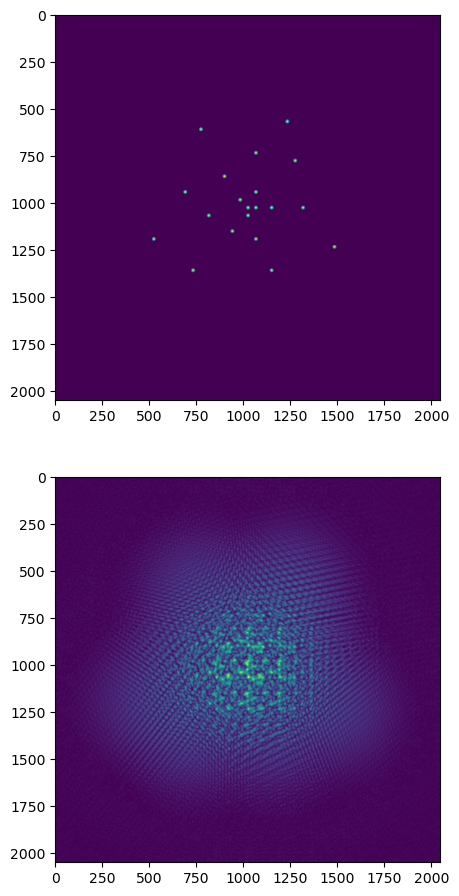

In [347]:
fig, (ax_u0, ax_uz ) = plt.subplots(2,1, figsize=(10,11))

ax_u0.imshow(np.abs(U_0), vmin=0, vmax=1)

ax_uz.imshow( (np.abs(U_z) ))
# ax_uz.imshow( np.fft.fftshift(np.abs(U_z) ))

plt.show()

In [345]:
U_z_random = U_z.copy()

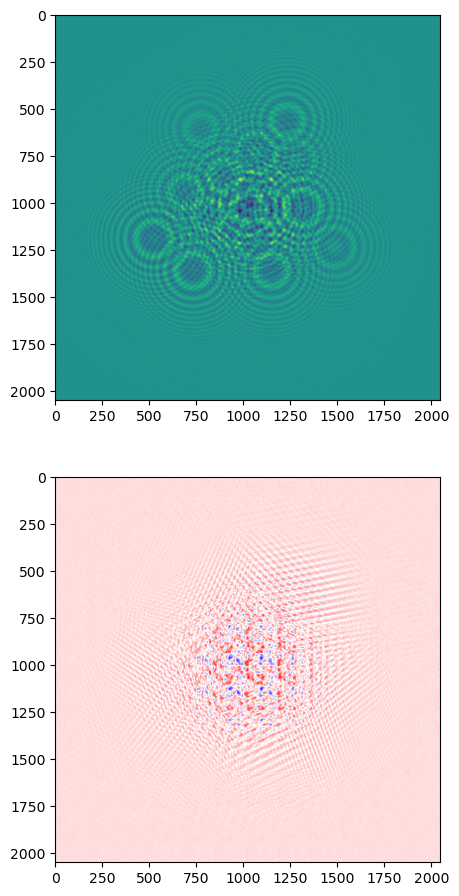

In [350]:
fig, (ax_u0, ax_uz ) = plt.subplots(2,1, figsize=(10,11))

ax_u0.imshow(np.real(U_z - U_z_random))

ax_uz.imshow( (np.abs(U_z) - np.abs(U_z_random) ), cmap='bwr')
# ax_uz.imshow( np.fft.fftshift(np.abs(U_z) ))

plt.show()

# Incoherent sim
---

In [581]:
U_WAVELENGTH = 500 * nm_
U_WAVENUMBER = 2*np.pi / U_WAVELENGTH
U_PIXELPITCH = 0.5 * mm_
U_SIZE_N = 2048
FOCAL_LEN1 = 1
FOCAL_LEN2 = 0.1
DIST_PROPAGATE = 1e4

print(U_SIZE_N*U_PIXELPITCH)
rowvec = U_PIXELPITCH * np.linspace( -U_SIZE_N//2, U_SIZE_N//2-1, U_SIZE_N, dtype=np.float64)
xx, yy =  np.meshgrid( rowvec, rowvec )
FIBER_XWIDTH = 50.0 * mm_
FIBER_YWIDTH = 50.0 * mm_
BEAM_WAIST = FIBER_XWIDTH / 2

rng = np.random.default_rng(seed=123)
FIBER_PHI = 0.0 * 2*pi*rng.random(FIBER_XY0.shape[0])
# FIBER_PHI = np.array([0.0, 0*pi])
U_PHASE_TIME_STD = 0.95
fvec = np.linspace( -U_SIZE_N//2, U_SIZE_N//2-1, U_SIZE_N, dtype=np.float64)
fxx, fyy = np.meshgrid( fvec, fvec )
smooth_const = int(0.1*U_SIZE_N)
circ_smooth = fo.circ2d(fxx,fyy, 0,0, smooth_const, smooth_const )


CDD_PIXELPITCH = 1 * mm_
ccd_size_x, ccd_size_y = U_SIZE_N*CDD_PIXELPITCH, U_SIZE_N*CDD_PIXELPITCH

U_0_ALL = []
U_Z_ALL = []
compare_propagator = False
U_Z_ALL_AS = []

for i in tqdm(range(23)):
    U_0 = np.zeros_like(xx)
    # make initial field
    for xy,phi in zip(FIBER_XY0,FIBER_PHI):
        x0, y0 = xy

        Ui = fo.circ2d(xx, yy, x0, y0, FIBER_XWIDTH, FIBER_YWIDTH) 

        Efld_GaussiaBeam = fo.efield_guassian_2d( xx - x0, yy - y0, U_WAVELENGTH, BEAM_WAIST, dist_from_waist=0 )

        Ui = Ui * Efld_GaussiaBeam 
        # add incoherent time phase
        # U_0_phase = np.exp(1j*2*pi*U_PHASE_TIME_STD*rng.random() )
        phi_time = 2*pi*U_PHASE_TIME_STD*rng.random(xx.shape) 
        phi_time = fo.smooth_convolve( phi_time, circ_smooth )

        U_0_phasor = np.exp(1j*(phi + phi_time))

        Ui = Ui * U_0_phasor

        U_0 = U_0 + Ui
    
    U_0_ALL.append(U_0)
    
    # init monochromatic sim
    F = ds.MonochromaticField(U_WAVELENGTH, U_PIXELPITCH*U_SIZE_N, U_PIXELPITCH*U_SIZE_N, U_SIZE_N, U_SIZE_N )
    F.E = U_0.copy()
    F.zoom_propagate(DIST_PROPAGATE, x_interval=[-ccd_size_x/2, ccd_size_x/2], y_interval=[-ccd_size_y/2, ccd_size_y/2])
    # F.propagate(DIST_PROPAGATE)
    U_z = F.E.copy() # diffraction of initial field
    U_Z_ALL.append(U_z)
    
    if compare_propagator:
        UZ, _, _ = fo.prop_angspect( U_0, DIST_PROPAGATE, U_WAVELENGTH, U_PIXELPITCH)
        U_Z_ALL_AS.append(UZ)
    else:
        U_Z_ALL_AS.append(xx)



1.024


100%|██████████| 23/23 [03:02<00:00,  7.92s/it]


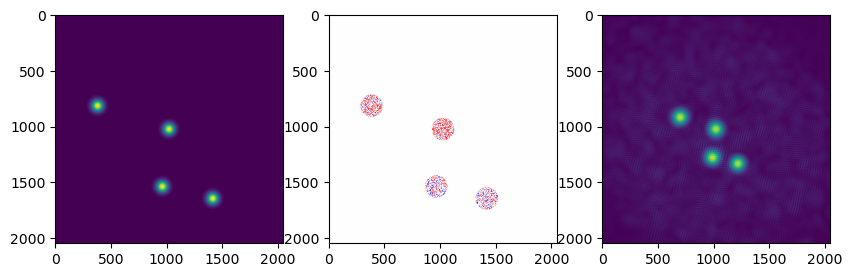

In [582]:
fig, ( ax_u0_mag, ax_u0_phi, ax_uz ) = plt.subplots(1,3, figsize=(10,11))

ax_u0_mag.imshow(np.abs(U_0_ALL[0]), vmin=0, vmax=1, cmap='viridis')
ax_u0_phi.imshow(np.angle(U_0_ALL[0]), vmin=-pi, vmax=pi, cmap='bwr')


ax_uz.imshow( np.abs(U_Z_ALL[0]) )
# ax_uz.imshow( np.abs(U_Z_ALL_AS[0]) )

plt.show()

In [583]:
I_Z_SUM = np.zeros_like(xx)
U_Z_SUM = np.zeros_like(U_0)
I_Z_AS_SUM = np.zeros_like(xx)
for i,u in enumerate(U_Z_ALL):
    I_Z_SUM = I_Z_SUM + np.abs(u)
    U_Z_SUM = U_Z_SUM + u
    I_Z_AS_SUM = I_Z_AS_SUM + np.abs(U_Z_ALL_AS[i])

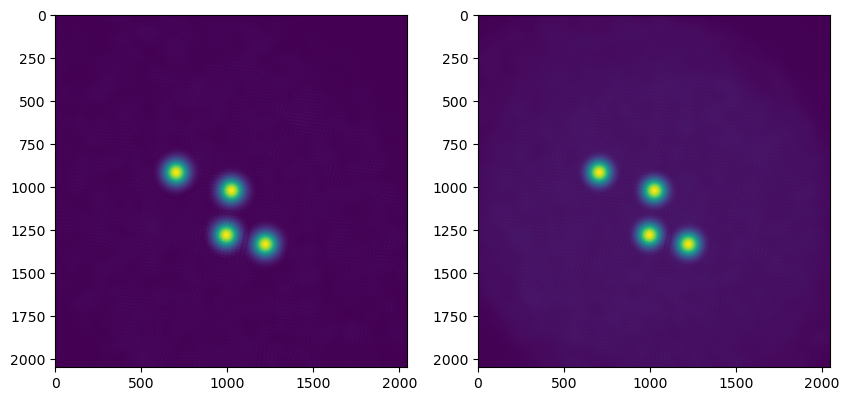

In [584]:
fig, (ax_u0, ax_uz ) = plt.subplots(1,2, figsize=(10,11))

ax_u0.imshow(np.abs(U_Z_SUM))
# ax_u0.imshow(np.abs(U_0_ALL[0]))
# ax_u0.imshow( I_Z_AS_SUM )

ax_uz.imshow( I_Z_SUM )

plt.show()

In [585]:
iz = (I_Z_SUM - I_Z_SUM.min()) / ( I_Z_SUM.max() - I_Z_SUM.min())
iz = np.array(iz * 255, dtype=int)

In [586]:
from scipy.io import savemat
savemat( "C:/Users/1167306/py-libs/optics/images/truth_image.mat", mdict={"image":iz})

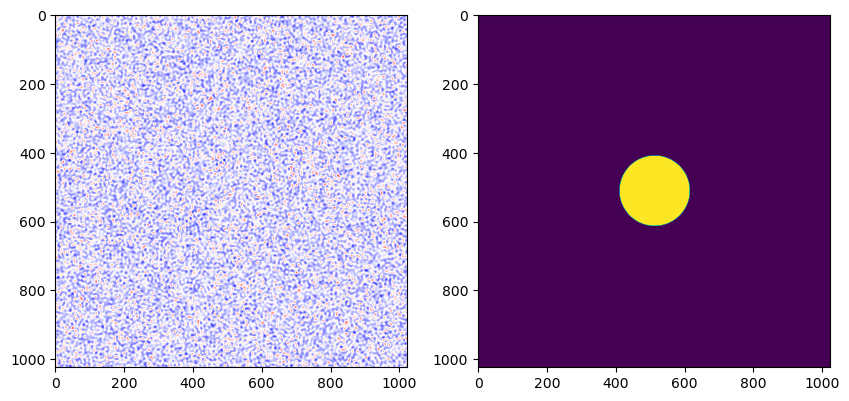

In [564]:
# circ_smooth = fo.circ2d(xx,yy, 32,32, 22, 21 )

U_0_phase = 2*pi*U_PHASE_TIME_STD*rng.random(xx.shape)
U_0_phase = fo.smooth_convolve( U_0_phase, circ_smooth )
fig, (ax_u0, ax_uz ) = plt.subplots(1,2, figsize=(10,11))

# ax_u0.imshow(np.abs(U_Z_SUM))
# ax_u0.imshow(np.abs(U_0_ALL[0]))
ax_u0.imshow( U_0_phase,vmin=0, vmax=2*pi, cmap='bwr' )

ax_uz.imshow( circ_smooth )

plt.show()

In [537]:
U_0_phase.min()
U_0_phase.max()

5.654851233659695

# Mutual coherence calculation
---

In [ ]:
from scipy.io import loadmat

aperture_locations_fe = loadmat()